# Deploying Iris-detection model using Vertex AI


## Overview

In this tutorial, you build a scikit-learn model and deploy it on Vertex AI using the custom container method. You use the FastAPI Python web server framework to create a prediction endpoint. You also incorporate a preprocessor from training pipeline into your online serving application.

Learn more about [Custom training](https://cloud.google.com/vertex-ai/docs/training/custom-training) and [Vertex AI Prediction](https://cloud.google.com/vertex-ai/docs/predictions/get-predictions).

### Objective

In this notebook, you learn how to create, deploy and serve a custom classification model on Vertex AI. This notebook focuses more on deploying the model than on the design of the model itself. 


This tutorial uses the following Vertex AI services and resources:

- Vertex AI models
- Vertex AI endpoints

The steps performed include:

- Train a model that uses flower's measurements as input to predict the class of iris.
- Save the model and its serialized pre-processor.
- Build a FastAPI server to handle predictions and health checks.
- Build a custom container with model artifacts.
- Upload and deploy custom container to Vertex AI Endpoints.

### Dataset

This tutorial uses R.A. Fisher's Iris dataset, a small and popular dataset for machine learning experiments. Each instance has four numerical features, which are different measurements of a flower, and a target label that
categorizes the flower into: **Iris setosa**, **Iris versicolour** and **Iris virginica**.

This tutorial uses [a version of the Iris dataset available in the
scikit-learn library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage
* Artifact Registry
* Cloud Build

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), [Artifact Registry pricing](https://cloud.google.com/artifact-registry/pricing) and [Cloud Build pricing](https://cloud.google.com/build/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Get started

### Install Vertex AI SDK for Python and other required packages



In [1]:

# Vertex SDK for Python
! pip3 install --upgrade --quiet  google-cloud-aiplatform

### Set Google Cloud project information 
Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [2]:
PROJECT_ID = "proven-cosmos-461108-i0"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [5]:
BUCKET_URI = f"gs://mlops-course-{PROJECT_ID}-week-05"  # @param {type:"string"}

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [6]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://mlops-course-proven-cosmos-461108-i0-week-05/...


### Initialize Vertex AI SDK for Python

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). 

In [7]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

### Import the required libraries

In [8]:
import os
import sys

### Configure resource names

Set a name for the following parameters:

`MODEL_ARTIFACT_DIR` - Folder directory path to your model artifacts within a Cloud Storage bucket, for example: "my-models/fraud-detection/trial-4"

`REPOSITORY` - Name of the Artifact Repository to create or use.

`IMAGE` - Name of the container image that is pushed to the repository.

`MODEL_DISPLAY_NAME` - Display name of Vertex AI model resource.

In [9]:
MODEL_ARTIFACT_DIR = "my-models/iris-classifier-week-5"  # @param {type:"string"}
REPOSITORY = "iris-classifier-repo"  # @param {type:"string"}
IMAGE = "iris-classifier-img"  # @param {type:"string"}
MODEL_DISPLAY_NAME = "iris-classifier"  # @param {type:"string"}

# Set the defaults if no names were specified
if MODEL_ARTIFACT_DIR == "[your-artifact-directory]":
    MODEL_ARTIFACT_DIR = "custom-container-prediction-model"

if REPOSITORY == "[your-repository-name]":
    REPOSITORY = "custom-container-prediction"

if IMAGE == "[your-image-name]":
    IMAGE = "sklearn-fastapi-server"

if MODEL_DISPLAY_NAME == "[your-model-display-name]":
    MODEL_DISPLAY_NAME = "sklearn-custom-container"

## Simple Decision Tree model
Build a Decision Tree model on iris data

In [10]:
import mlflow
from mlflow import MlflowClient
from mlflow.models import infer_signature
from pprint import pprint

In [11]:
mlflow.set_tracking_uri("http://127.0.0.1:8100") # AS ITS ON THE SAME MACHINE IT CAN RACK TO THE MLFLOW INSTANCE RUNNING
client = MlflowClient(mlflow.get_tracking_uri())
all_experiments = client.search_experiments()
print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/668621125523513574', creation_time=1751800534348, experiment_id='668621125523513574', last_update_time=1751800534348, lifecycle_stage='active', name='IRIS Classifier: Mlflow Quickstart', tags={}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1751798426772, experiment_id='0', last_update_time=1751798426772, lifecycle_stage='active', name='Default', tags={}>]


In [12]:
mlflow.get_tracking_uri()

'http://127.0.0.1:8100'

In [13]:
mlflow.set_experiment("IRIS Classifier: Mlflow Quickstart")

<Experiment: artifact_location='mlflow-artifacts:/668621125523513574', creation_time=1751800534348, experiment_id='668621125523513574', last_update_time=1751800534348, lifecycle_stage='active', name='IRIS Classifier: Mlflow Quickstart', tags={}>

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [15]:
data = pd.read_csv("data/iris.csv")
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Model Building

In [16]:
train, test = train_test_split(data, test_size = 0.4, stratify = data['species'], random_state = 42)
X_train = train[['sepal_length','sepal_width','petal_length','petal_width']]
y_train = train.species
X_test = test[['sepal_length','sepal_width','petal_length','petal_width']]
y_test = test.species

In [17]:
params = {"max_depth": 3, "random_state": 1}
dec_clf = DecisionTreeClassifier(max_depth = 3, random_state = 1)
dec_clf.fit(X_train,y_train)
y_pred = dec_clf.predict(X_test)
print('The accuracy of the Decision Tree is',"{:.3f}".format(accuracy_score(y_test,y_pred)))

The accuracy of the Decision Tree is 0.983


## Hyperparam Tuning

In [25]:
from sklearn.model_selection import RandomizedSearchCV

In [24]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 5],
}

In [27]:
cv = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_grid)

In [29]:
cv.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4],
                                        'min_samples_split': [2, 5]})

In [30]:
cv.best_params_

{'min_samples_split': 5, 'max_depth': 2, 'criterion': 'entropy'}

In [31]:
dec_clf = cv.best_estimator_

### Decision Tree Plot

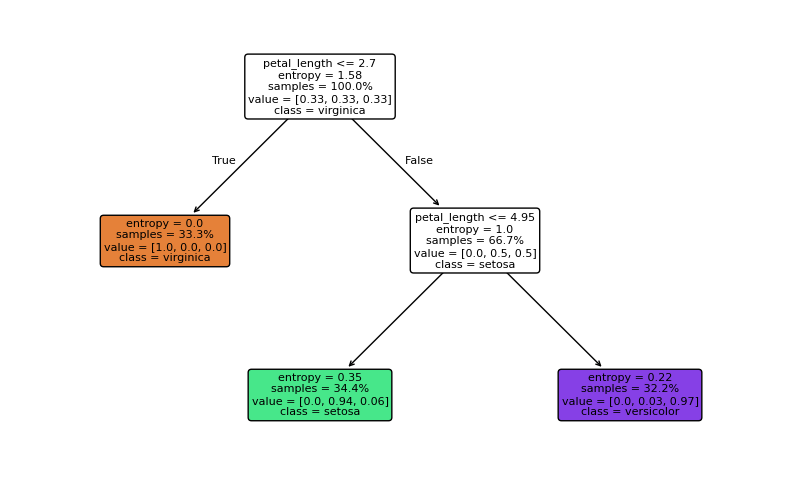

In [32]:
plt.figure(figsize=(10,6))
plot_tree(
    dec_clf,
    feature_names=data.columns[:-1],
    class_names=train.species.unique(),
    filled=True,
    rounded=True,
    fontsize=8,
    impurity=True,
    proportion=True,
    precision=2,
)
plt.show()

### Model Metrics

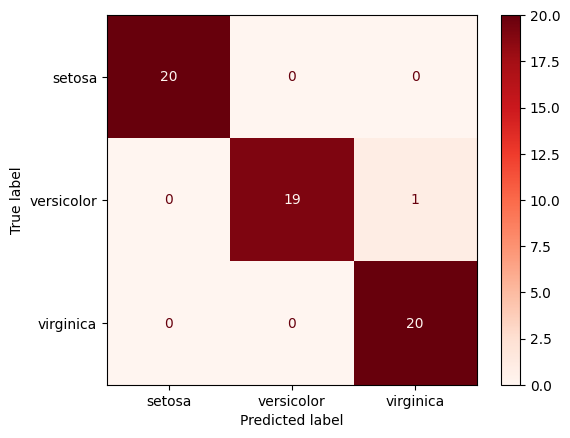

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Reds")
plt.show()

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        20
  versicolor       1.00      0.95      0.97        20
   virginica       0.95      1.00      0.98        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [35]:
accuracy = accuracy_score(y_test,y_pred)

### Model Export

In [36]:
import pickle
import joblib

joblib.dump(dec_clf, "artifacts/model.joblib")

['artifacts/model.joblib']

### Upload model artifacts and custom code to Cloud Storage

Before you can deploy your model for serving, Vertex AI needs access to the following files in Cloud Storage:

* `model.joblib` (model artifact)
* `preprocessor.pkl` (model artifact)

Run the following commands to upload your files:

In [37]:
!gsutil cp artifacts/model.joblib {BUCKET_URI}/{MODEL_ARTIFACT_DIR}/

Copying file://artifacts/model.joblib [Content-Type=application/octet-stream]...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      


## Log the run to MLflow

In [40]:
with mlflow.start_run():
    mlflow.log_params(cv.best_params_)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.set_tag("Training Info","Decision tree model for IRIS data")
    
    signature = infer_signature(X_train, dec_clf.predict(X_train))
    
    model_info = mlflow.sklearn.log_model(
        sk_model=dec_clf,
        name="iris_model_best",
        signature=signature,
        input_example=X_train,
        registered_model_name="IRIS-classifier-dt"
    )

Registered model 'IRIS-classifier-dt' already exists. Creating a new version of this model...
2025/07/06 17:53:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: IRIS-classifier-dt, version 6


🏃 View run suave-stoat-92 at: http://127.0.0.1:8100/#/experiments/668621125523513574/runs/c46badc314a7464ba2724723d5ccf387
🧪 View experiment at: http://127.0.0.1:8100/#/experiments/668621125523513574


Created version '6' of model 'IRIS-classifier-dt'.
